In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
import os
print("Current directory:", os.getcwd())



Current directory: /content


In [ ]:
# Unzip to /content/dataset
!unzip "/content/drive/MyDrive/XRAY/data.zip" -d /content/drive/MyDrive/Ctscan

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Ctscan/brisc2025/classification_task/train/glioma/brisc2025_train_00004_gl_ax_t1.jpg  
  inflating: /content/drive/MyDrive/Ctscan/brisc2025/classification_task/train/glioma/brisc2025_train_00005_gl_ax_t1.jpg  
  inflating: /content/drive/MyDrive/Ctscan/brisc2025/classification_task/train/glioma/brisc2025_train_00006_gl_ax_t1.jpg  
  inflating: /content/drive/MyDrive/Ctscan/brisc2025/classification_task/train/glioma/brisc2025_train_00007_gl_ax_t1.jpg  
  inflating: /content/drive/MyDrive/Ctscan/brisc2025/classification_task/train/glioma/brisc2025_train_00008_gl_ax_t1.jpg  
  inflating: /content/drive/MyDrive/Ctscan/brisc2025/classification_task/train/glioma/brisc2025_train_00009_gl_ax_t1.jpg  
  inflating: /content/drive/MyDrive/Ctscan/brisc2025/classification_task/train/glioma/brisc2025_train_00010_gl_ax_t1.jpg  
  inflating: /content/drive/MyDrive/Ctscan/brisc2025/classification_task/train/glioma/br

In [ ]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support


import warnings
warnings.filterwarnings ('ignore')

In [ ]:
dataset_path = Path("/content/drive/MyDrive/Ctscan/brisc2025/classification_task")
dataset_path

Path('/content/drive/MyDrive/Ctscan/brisc2025/classification_task')

In [ ]:
files = list(dataset_path.glob("*/*.jpg"))
print(f'Total Images = {len(files)}')

Total Images = 0


In [ ]:
dataset_path.ls()


(#2) [Path('/content/drive/MyDrive/Ctscan/brisc2025/classification_task/test'),Path('/content/drive/MyDrive/Ctscan/brisc2025/classification_task/train')]

In [ ]:
dls = ImageDataLoaders.from_folder(
    dataset_path, valid_pct=0.2,
    item_tfms=Resize(224),
    batch_tfms=[
        *aug_transforms(flip_vert=True, max_rotate=30.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2),
    ]
)

In [ ]:
len(dls.train_ds)

4800

In [ ]:
len(dls.valid_ds)

1200

In [ ]:
dls

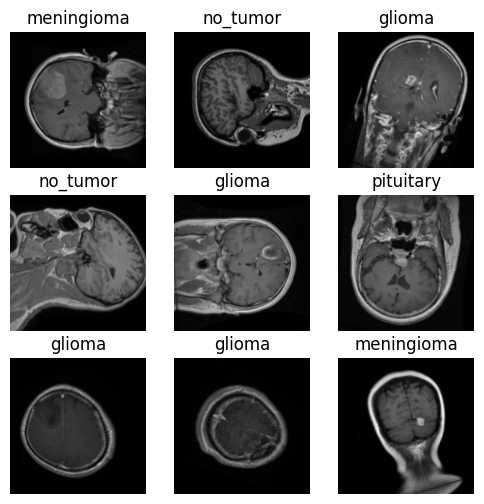

In [ ]:
dls.show_batch(max_n=9, figsize=(6,6))
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def multiclass_precision(preds, targs):
    # Eğer tensör ise, CPU'ya al ve numpy dizisine çevir
    if hasattr(preds, 'detach'):
        preds = preds.detach().cpu().numpy()
    if hasattr(targs, 'detach'):
        targs = targs.detach().cpu().numpy()
    # Eğer logits gibi çok boyutlu çıktı ise argmax al
    if preds.ndim > 1:
        preds = preds.argmax(axis=1)
    return precision_score(targs, preds, average='macro')

def multiclass_recall(preds, targs):
    if hasattr(preds, 'detach'):
        preds = preds.detach().cpu().numpy()
    if hasattr(targs, 'detach'):
        targs = targs.detach().cpu().numpy()
    if preds.ndim > 1:
        preds = preds.argmax(axis=1)
    return recall_score(targs, preds, average='macro')

def multiclass_f1(preds, targs):
    if hasattr(preds, 'detach'):
        preds = preds.detach().cpu().numpy()
    if hasattr(targs, 'detach'):
        targs = targs.detach().cpu().numpy()
    if preds.ndim > 1:
        preds = preds.argmax(axis=1)
    return f1_score(targs, preds, average='macro')

In [ ]:
from fastai.losses import CrossEntropyLossFlat
from fastai.vision.all import vision_learner, resnet34

learn = vision_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, multiclass_precision, multiclass_recall, multiclass_f1], model_dir=Path("/kaggle/working/models"))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 176MB/s]


In [ ]:
from google.colab import drive
from pathlib import Path

# Mount Google Drive
drive.mount('/content/drive')

# Set export path in your Drive
learn.path = Path("/content/drive/MyDrive")
learn.export("model.pkl")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


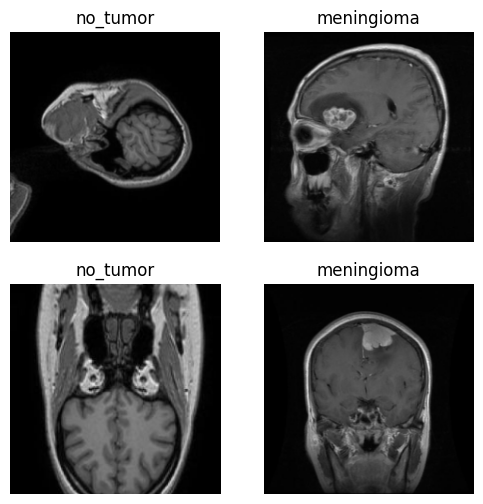

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224)
).dataloaders(dataset_path)

dls.show_batch(max_n=4)


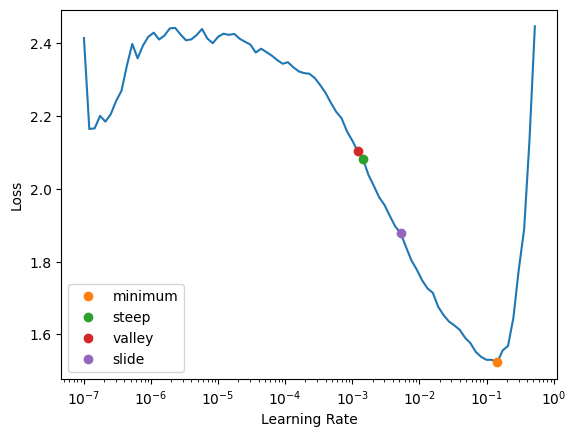

In [ ]:
from fastai.callback import *

suggest_funcs = (minimum, steep, valley, slide)
lrs = learn.lr_find(suggest_funcs=suggest_funcs)
plt.show()

In [ ]:
lrs

SuggestedLRs(minimum=0.014454397559165954, steep=0.0014454397605732083, valley=0.0012022644514217973, slide=0.005248074419796467)

In [ ]:
print(f"Önerilen minimum öğrenme oranı: {lrs.minimum}, en dik eğim noktası: {lrs.steep}")

Önerilen minimum öğrenme oranı: 0.014454397559165954, en dik eğim noktası: 0.0014454397605732083


In [ ]:
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback

# Callback'leri tanımla
early_stopping = EarlyStoppingCallback(monitor='valid_loss', patience=10)
model_checkpoint = SaveModelCallback(monitor='valid_loss', fname='best_model')

# Eğitim
learn.fit_one_cycle(50, lr_max=lrs.minimum, cbs=[early_stopping, model_checkpoint])

epoch,train_loss,valid_loss,accuracy,multiclass_precision,multiclass_recall,multiclass_f1,time
0,0.037864,0.066873,0.984167,0.985557,0.983758,0.984111,00:45
1,0.038763,0.074813,0.984167,0.984737,0.983616,0.983535,00:45
2,0.046046,0.103585,0.971667,0.973680,0.972503,0.971953,00:46
3,0.037819,0.075030,0.983333,0.985391,0.983248,0.983723,00:46
4,0.045817,0.155612,0.966667,0.970517,0.967948,0.967475,00:46
5,0.056976,0.115671,0.971667,0.973967,0.971328,0.971689,00:47
6,0.069849,1.117056,0.770833,0.871970,0.761883,0.772335,00:45
7,0.085782,0.203072,0.952500,0.956889,0.949508,0.949903,00:46
8,0.098657,0.099773,0.971667,0.972419,0.972370,0.971261,00:45
9,0.092367,0.220320,0.949167,0.956736,0.951320,0.950692,00:46


Better model found at epoch 0 with valid_loss value: 0.06687270104885101.
No improvement since epoch 0: early stopping


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

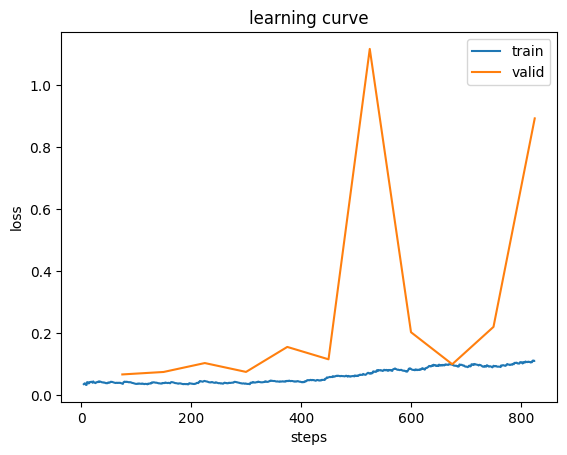

In [ ]:
learn.recorder.plot_loss()

In [ ]:
img = PILImage.create("/content/drive/MyDrive/Ctscan/brisc2025/classification_task/test/no_tumor/brisc2025_test_00575_no_ax_t1.jpg")  # Test için bir görsel yükle
learn.predict(img)

('no_tumor',
 tensor(2),
 tensor([3.6063e-09, 1.1191e-08, 1.0000e+00, 9.2299e-08]))

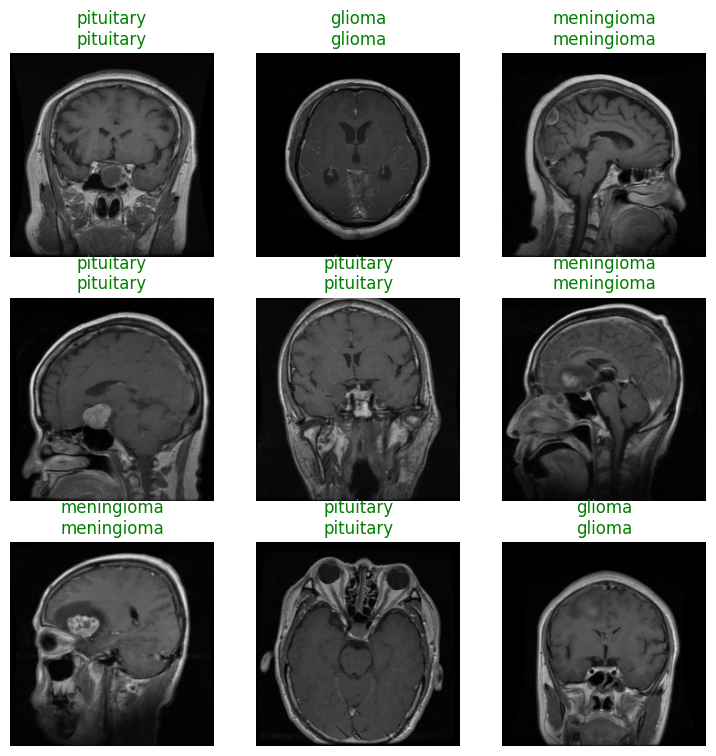

In [ ]:
learn.show_results()

In [ ]:
from sklearn.metrics import classification_report
preds, targets = learn.get_preds()
class_report = classification_report(targets, torch.argmax(preds, dim=1), target_names=dls.vocab)
print(class_report)

              precision    recall  f1-score   support

      glioma       0.98      0.98      0.98       295
  meningioma       0.98      0.97      0.98       341
    no_tumor       0.99      0.98      0.99       235
   pituitary       0.99      1.00      0.99       329

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200



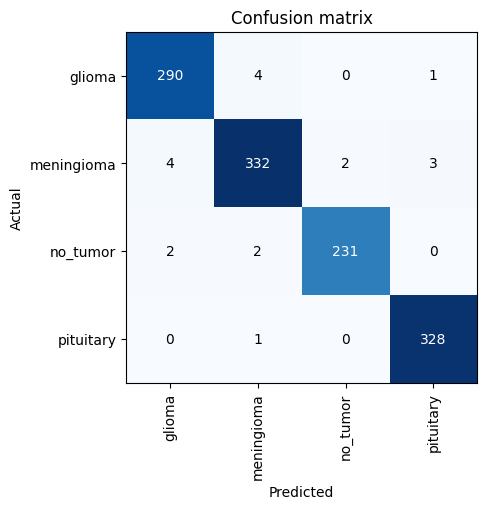

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5))
plt.show()


In [ ]:
dataset_path


Path('/content/drive/MyDrive/Ctscan/brisc2025/classification_task')

In [ ]:
preds, y_true, _ = learn.get_preds(dl=dls.valid, with_decoded=True)

# Eğer preds çok boyutlu ise argmax alarak tahmin etiketlerini elde ediyoruz
preds_labels = preds.argmax(dim=1)


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(y_true, preds_labels, average='weighted')

# Accuracy'yi ayrı hesaplamak için get_preds'i tekrar kullanabiliriz:
acc = accuracy(*learn.get_preds(dl=dls.valid))

print(f"Validation Seti Performansı:")
print(f"Accuracy: {acc.item():.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Validation Seti Performansı:
Accuracy: 0.2375
Precision: 0.2302
Recall: 0.2375
F1 Score: 0.1485


Validation Seti Performansı:
Accuracy:  0.2375
Precision: 0.2302
Recall:    0.2375
F1 Score:  0.1485


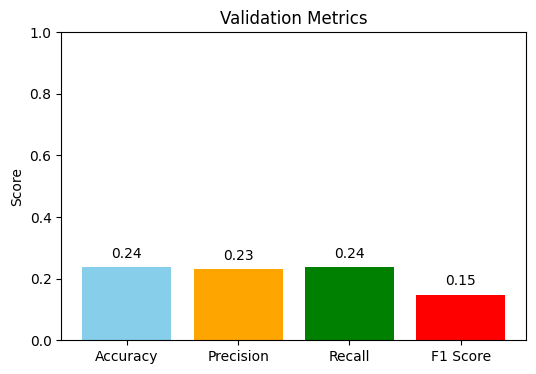

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np

# Calculate precision, recall, f1
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, preds_labels, average='weighted'
)

# Accuracy (separate)
acc = accuracy(*learn.get_preds(dl=dls.valid))

# Print results
print("Validation Seti Performansı:")
print(f"Accuracy:  {acc.item():.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# --- Plot ---
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [acc.item(), precision, recall, f1]

plt.figure(figsize=(6,4))
bars = plt.bar(metrics, values, color=['skyblue', 'orange', 'green', 'red'])
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Validation Metrics")

# Add values on top of bars
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f"{val:.2f}",
             ha='center', va='bottom', fontsize=10)

plt.show()


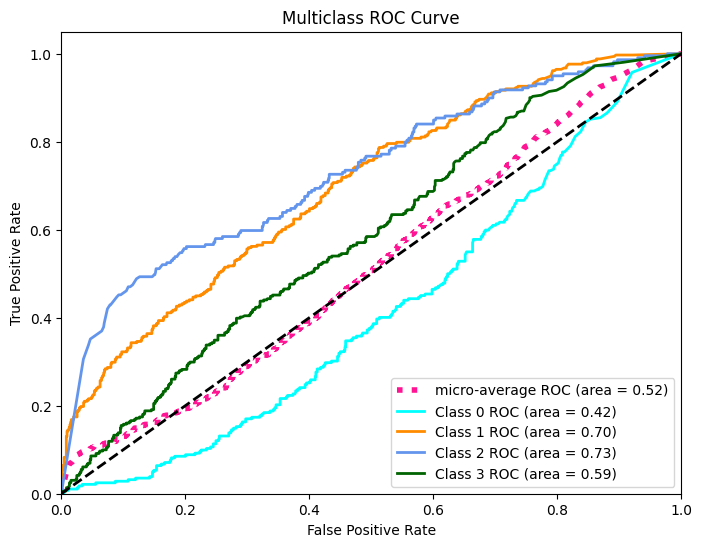

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import torch

preds, y_true = learn.get_preds(dl=dls.valid, with_decoded=False)

probs = torch.softmax(preds, dim=1).detach().cpu().numpy()
y_true_np = y_true.detach().cpu().numpy()

n_classes = probs.shape[1]
y_true_bin = label_binarize(y_true_np, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} ROC (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()


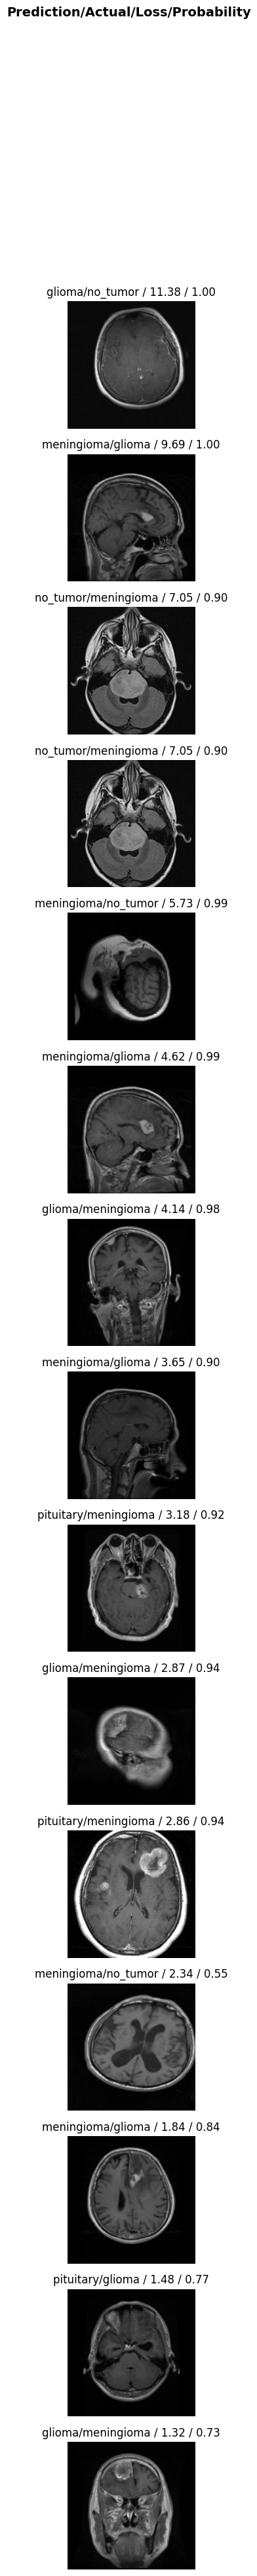

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(15, nrows=15)

In [ ]:
img = PILImage.create("/content/drive/MyDrive/Ctscan/brisc2025/classification_task/test/no_tumor/brisc2025_test_00579_no_ax_t1.jpg")  # Test için bir görsel yükle
pred, pred_idx, probs = learn.predict(img)
print(f"Prediction: {pred}, Probability: {probs[pred_idx]:.4f}")

Prediction: no_tumor, Probability: 1.0000


Prediction: no_tumor, Probability: 1.0000


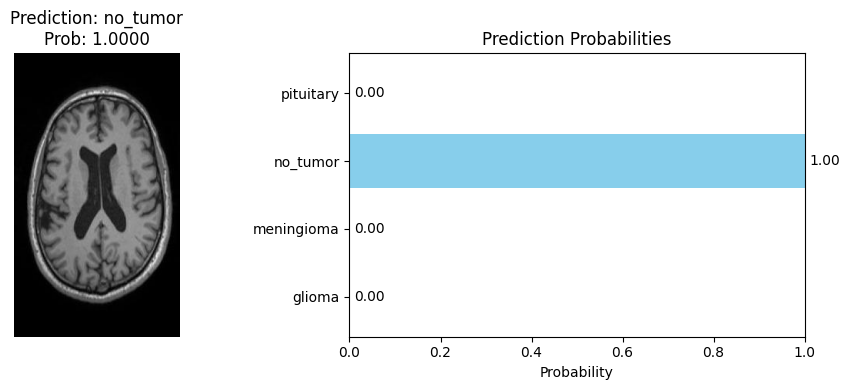

In [ ]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
import numpy as np

# Load image
img_path = "/content/drive/MyDrive/Ctscan/brisc2025/classification_task/test/no_tumor/brisc2025_test_00579_no_ax_t1.jpg"
img = PILImage.create(img_path)

# Predict
pred, pred_idx, probs = learn.predict(img)

# Print text result
print(f"Prediction: {pred}, Probability: {probs[pred_idx]:.4f}")

# --- Plot ---
plt.figure(figsize=(10,4))

# Show the image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {pred}\nProb: {probs[pred_idx]:.4f}")

# Show probability bar chart
plt.subplot(1, 2, 2)
class_names = learn.dls.vocab
y_pos = np.arange(len(class_names))
plt.barh(y_pos, probs, align='center', color='skyblue')
plt.yticks(y_pos, class_names)
plt.xlabel('Probability')
plt.xlim(0, 1)
plt.title('Prediction Probabilities')

# Add values on bars
for i, v in enumerate(probs):
    plt.text(v + 0.01, i, f"{v:.2f}", va='center')

plt.tight_layout()
plt.show()
